# 💰 Financial Intelligence Platform
## Stock Price Prediction with LSTM + Future Forecasting

**Dataset:** Kaggle S&P 500
**Hardware:** GTX 1660 Super


## Step 1: Install Dependencies


In [26]:
!pip install pandas numpy matplotlib seaborn scikit-learn tqdm tensorboard joblib opendatasets


## Step 2: Download Dataset


In [27]:
import opendatasets as od

od.download('https://www.kaggle.com/datasets/camnugent/sandp500')
print('✅ Dataset downloaded')


Skipping, found downloaded files in "./sandp500" (use force=True to force download)
✅ Dataset downloaded


## Step 3: Import Libraries


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from pathlib import Path
import time
import warnings
from datetime import datetime, timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

print('✅ Libraries imported')


✅ Libraries imported


In [29]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
print(f'✅ Seed: {RANDOM_SEED}')


✅ Seed: 42


In [30]:
if not torch.cuda.is_available():
    raise RuntimeError('GPU NOT DETECTED!')
device = torch.device('cuda')
print(f'✅ GPU: {torch.cuda.get_device_name(0)}')


✅ GPU: NVIDIA GeForce GTX 1660 SUPER


In [31]:
BASE_DIR = Path('/home/jami/Desktop/Hirable/FinancialIntelligence')
DIRS = {
    'data': BASE_DIR / 'data',
    'checkpoints': BASE_DIR / 'checkpoints',
    'logs': BASE_DIR / 'logs',
    'tensorboard': BASE_DIR / 'logs' / 'tensorboard',
    'results': BASE_DIR / 'results',
    'models': BASE_DIR / 'models',
}
for d in DIRS.values():
    d.mkdir(parents=True, exist_ok=True)
print('✅ Directories created')


✅ Directories created


## Step 4: Load & Prepare Data


In [32]:
df = pd.read_csv('sandp500/all_stocks_5yr.csv')
df_apple = df[df['Name'] == 'AAPL'].copy()
df_apple['date'] = pd.to_datetime(df_apple['date'])
df_apple = df_apple.sort_values('date').reset_index(drop=True)
print(f'✅ Data loaded: {df_apple.shape}')
print(f'   Date range: {df_apple["date"].min()} to {df_apple["date"].max()}')
df_apple.head()


✅ Data loaded: (1259, 7)
   Date range: 2013-02-08 00:00:00 to 2018-02-07 00:00:00


,date,open,high,low,close,volume,Name
0,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
2,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
3,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
4,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL


## Step 5: Technical Indicators


In [33]:
def add_technical_indicators(df):
    df = df.copy()
    df['MA_7'] = df['close'].rolling(window=7, min_periods=1).mean()
    df['MA_21'] = df['close'].rolling(window=21, min_periods=1).mean()
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14, min_periods=1).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    exp1 = df['close'].ewm(span=12, adjust=False).mean()
    exp2 = df['close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    df = df.iloc[30:].reset_index(drop=True)
    return df

df_apple = add_technical_indicators(df_apple)
print(f'✅ Indicators added: {df_apple.shape}')


✅ Indicators added: (1229, 12)


## Step 6: Configuration


In [34]:
SEQUENCE_LENGTH = 60
PREDICTION_HORIZON = 1
LSTM_HIDDEN_SIZE = 128
LSTM_NUM_LAYERS = 3
LSTM_DROPOUT = 0.2
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
WEIGHT_DECAY = 1e-5
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
CHECKPOINT_EVERY_N_EPOCHS = 5
FEATURE_COLS = ['close', 'volume', 'MA_7', 'MA_21', 'RSI', 'MACD']
print(f'✅ Config set')


✅ Config set


## Step 7: Prepare Sequences


In [35]:
def prepare_sequences(df, seq_len, horizon, features):
    data = df[features].values
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)
    X, y = [], []
    for i in range(seq_len, len(scaled) - horizon + 1):
        X.append(scaled[i-seq_len:i])
        y.append(scaled[i+horizon-1, 0])
    return np.array(X), np.array(y), scaler

X, y, scaler = prepare_sequences(df_apple, SEQUENCE_LENGTH, PREDICTION_HORIZON, FEATURE_COLS)
print(f'✅ Sequences: {X.shape}')
joblib.dump(scaler, DIRS['data'] / 'scaler.pkl')


✅ Sequences: (1169, 60, 6)


['/home/jami/Desktop/Hirable/FinancialIntelligence/data/scaler.pkl']

## Step 8: Split Data


In [36]:
n = len(X)
train_size = int(n * TRAIN_RATIO)
val_size = int(n * VAL_RATIO)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]
print(f'Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}')


Train: 818, Val: 175, Test: 176


## Step 9: DataLoaders


In [37]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = StockDataset(X_train, y_train)
val_dataset = StockDataset(X_val, y_val)
test_dataset = StockDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=0)
print('✅ DataLoaders ready')


✅ DataLoaders ready


## Step 10: LSTM Model


In [38]:
class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers>1 else 0)
        self.fc1 = nn.Linear(hidden_size, hidden_size//2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size//2, 1)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc1(out[:,-1,:])
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out.squeeze()

model = StockLSTM(len(FEATURE_COLS), LSTM_HIDDEN_SIZE, LSTM_NUM_LAYERS, LSTM_DROPOUT).to(device)
print(f'✅ Model: {sum(p.numel() for p in model.parameters()):,} params')


✅ Model: 342,145 params


## Step 11: Training Setup


In [39]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)
writer = SummaryWriter(str(DIRS['tensorboard']))
csv_log = DIRS['logs'] / 'training.csv'
with open(csv_log, 'w') as f:
    f.write('epoch,train_loss,val_loss,lr,time\n')
print('✅ Training setup complete')


✅ Training setup complete


## Step 12: Training Functions


In [40]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(loader)


## Step 13: Train Model


In [41]:
print('TRAINING')
print('='*80)
best_val_loss = float('inf')
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, val_loader, criterion, device)
    scheduler.step(val_loss)
    lr = optimizer.param_groups[0]['lr']
    epoch_time = time.time() - epoch_start
    
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}] {epoch_time:.1f}s')
    print(f'  Train: {train_loss:.6f} | Val: {val_loss:.6f}')
    
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    
    with open(csv_log, 'a') as f:
        f.write(f'{epoch+1},{train_loss:.6f},{val_loss:.6f},{lr:.6f},{epoch_time:.2f}\n')
    
    if (epoch+1) % CHECKPOINT_EVERY_N_EPOCHS == 0:
        torch.save(model.state_dict(), DIRS['checkpoints'] / f'checkpoint_{epoch+1}.pth')
        print(f'  ✓ Checkpoint saved')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), DIRS['checkpoints'] / 'best_model.pth')
        print(f'  ✓ BEST: {val_loss:.6f}')
    print('-'*80)

print(f'Total: {(time.time()-start_time)/60:.1f}m')
writer.close()


TRAINING
Epoch [1/50] 0.1s
  Train: 0.050537 | Val: 0.042402
  ✓ BEST: 0.042402
--------------------------------------------------------------------------------
Epoch [2/50] 0.1s
  Train: 0.009258 | Val: 0.013189
  ✓ BEST: 0.013189
--------------------------------------------------------------------------------
Epoch [3/50] 0.1s
  Train: 0.004105 | Val: 0.007993
  ✓ BEST: 0.007993
--------------------------------------------------------------------------------
Epoch [4/50] 0.1s
  Train: 0.003402 | Val: 0.003696
  ✓ BEST: 0.003696
--------------------------------------------------------------------------------
Epoch [5/50] 0.1s
  Train: 0.003183 | Val: 0.003336
  ✓ Checkpoint saved
  ✓ BEST: 0.003336
--------------------------------------------------------------------------------
Epoch [6/50] 0.1s
  Train: 0.003203 | Val: 0.003121
  ✓ BEST: 0.003121
--------------------------------------------------------------------------------
Epoch [7/50] 0.1s
  Train: 0.002810 | Val: 0.005281
------

## Step 14: Evaluate Model


In [42]:
model.load_state_dict(torch.load(DIRS['checkpoints'] / 'best_model.pth'))
model.eval()

preds, targs = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds.extend(outputs.cpu().numpy())
        targs.extend(targets.numpy())

preds = np.array(preds)
targs = np.array(targs)

dummy = np.zeros((len(preds), len(FEATURE_COLS)))
dummy[:,0] = preds
preds_price = scaler.inverse_transform(dummy)[:,0]
dummy[:,0] = targs
targs_price = scaler.inverse_transform(dummy)[:,0]

mae = mean_absolute_error(targs_price, preds_price)
rmse = np.sqrt(mean_squared_error(targs_price, preds_price))
r2 = r2_score(targs_price, preds_price)

print(f'TEST RESULTS:')
print(f'MAE: ${mae:.2f}')
print(f'RMSE: ${rmse:.2f}')
print(f'R2: {r2:.4f}')


TEST RESULTS:
MAE: $8.93
RMSE: $10.06
R2: 0.0249


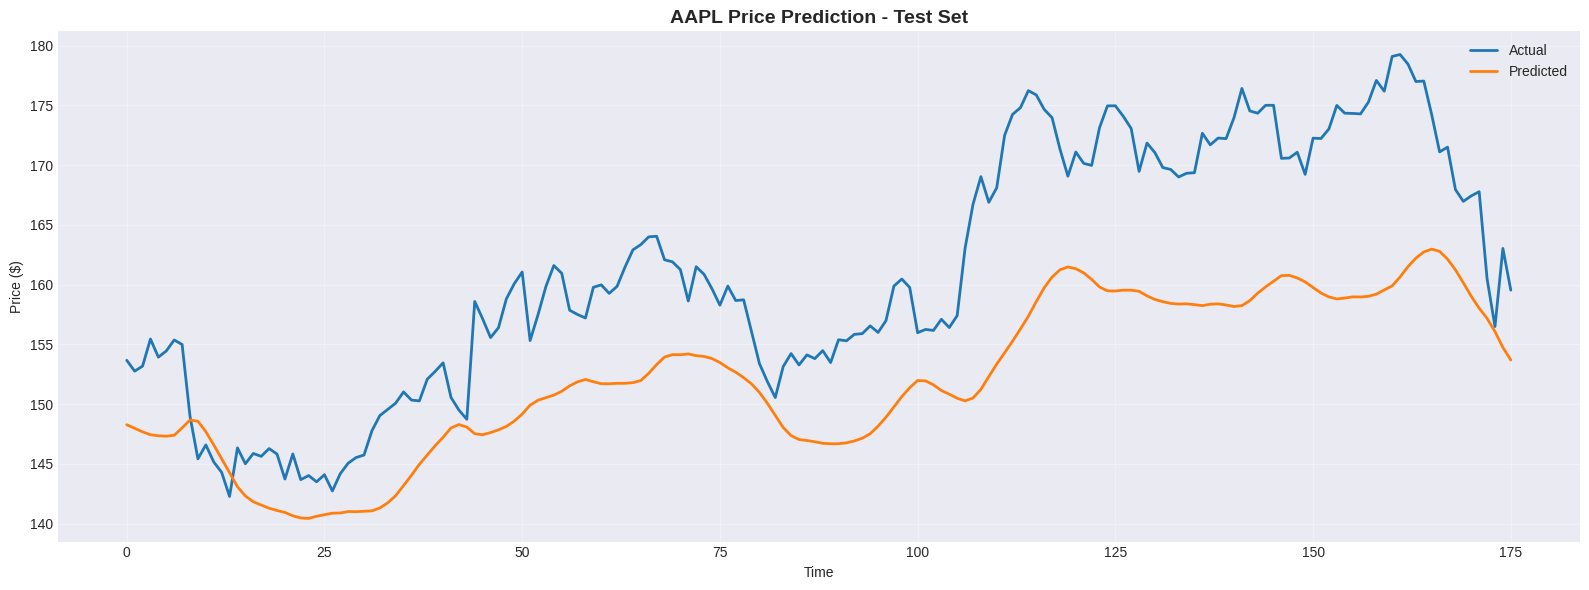

In [43]:
plt.figure(figsize=(16, 6))
plt.plot(targs_price, label='Actual', linewidth=2)
plt.plot(preds_price, label='Predicted', linewidth=2)
plt.title('AAPL Price Prediction - Test Set', fontsize=14, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(DIRS['results'] / 'test_predictions.png', dpi=150)
plt.show()


## Step 15: FUTURE PREDICTIONS 🔮


In [44]:
print('='*80)
print('📈 FUTURE STOCK PREDICTIONS')
print('='*80)

model.eval()
scaler = joblib.load(DIRS['data'] / 'scaler.pkl')
recent_data = df_apple[FEATURE_COLS].tail(SEQUENCE_LENGTH).values
current_price = df_apple['close'].iloc[-1]
current_date = df_apple['date'].iloc[-1]

print(f'Current Price: ${current_price:.2f}')
print(f'Date: {current_date.strftime("%Y-%m-%d")}')
print('='*80)


📈 FUTURE STOCK PREDICTIONS
Current Price: $159.54
Date: 2018-02-07


In [47]:
def predict_future(model, scaler, recent_data, feature_cols, days_ahead, device):
    model.eval()
    scaled_input = scaler.transform(recent_data)
    predictions = []
    current_sequence = scaled_input.copy()
    
    for day in range(days_ahead):
        input_tensor = torch.FloatTensor(current_sequence).unsqueeze(0).to(device)
        with torch.no_grad():
            pred_scaled = model(input_tensor).cpu().numpy()
            # FIX: Handle both scalar and array outputs
            if pred_scaled.ndim == 0:
                pred_scaled = float(pred_scaled)
            else:
                pred_scaled = pred_scaled[0]
        
        predictions.append(pred_scaled)
        new_row = current_sequence[-1].copy()
        new_row[0] = pred_scaled
        current_sequence = np.vstack([current_sequence[1:], new_row])
    
    final_pred = predictions[-1]
    dummy = np.zeros((1, len(feature_cols)))
    dummy[0, 0] = final_pred
    predicted_price = scaler.inverse_transform(dummy)[0, 0]
    
    volatility = np.std(df_apple['close'].tail(30).pct_change()) * np.sqrt(days_ahead)
    lower = predicted_price * (1 - 1.96 * volatility)
    upper = predicted_price * (1 + 1.96 * volatility)
    
    return predicted_price, (lower, upper)

print('✅ Prediction function ready')

✅ Prediction function ready


In [48]:
INTERVALS = {'1 Day': 1, '5 Days': 5, '10 Days': 10, '30 Days': 30, '60 Days': 60, '90 Days': 90}

predictions_summary = []
for name, days in INTERVALS.items():
    pred, (lower, upper) = predict_future(model, scaler, recent_data, FEATURE_COLS, days, device)
    change_pct = ((pred - current_price) / current_price) * 100
    direction = '📈 UP' if change_pct > 0 else '📉 DOWN'
    
    predictions_summary.append({
        'Interval': name,
        'Days': days,
        'Predicted_Price': pred,
        'Lower_95': lower,
        'Upper_95': upper,
        'Change_Dollar': pred - current_price,
        'Change_Percent': change_pct,
        'Direction': direction
    })
    
    print(f'{name}: ${pred:.2f} ({change_pct:+.2f}%) {direction}')
    print(f'  95% CI: ${lower:.2f} - ${upper:.2f}')

print('='*80)


1 Day: $152.79 (-4.23%) 📉 DOWN
  95% CI: $148.22 - $157.37
5 Days: $150.05 (-5.95%) 📉 DOWN
  95% CI: $140.01 - $160.09
10 Days: $148.51 (-6.92%) 📉 DOWN
  95% CI: $134.45 - $162.56
30 Days: $147.74 (-7.40%) 📉 DOWN
  95% CI: $123.52 - $171.96
60 Days: $147.73 (-7.40%) 📉 DOWN
  95% CI: $113.48 - $181.97
90 Days: $147.73 (-7.40%) 📉 DOWN
  95% CI: $105.78 - $189.67


In [49]:
predictions_df = pd.DataFrame(predictions_summary)
print('\nPREDICTIONS TABLE:')
print(predictions_df.to_string(index=False))
predictions_df.to_csv(DIRS['results'] / 'future_predictions.csv', index=False)
print(f'\n✅ Saved to {DIRS["results"] / "future_predictions.csv"}')



PREDICTIONS TABLE:
Interval  Days  Predicted_Price   Lower_95   Upper_95  Change_Dollar  Change_Percent Direction
   1 Day     1       152.794804 148.221803 157.367805      -6.745196       -4.227903    📉 DOWN
  5 Days     5       150.048345 140.006606 160.090084      -9.491655       -5.949389    📉 DOWN
 10 Days    10       148.507488 134.452157 162.562818     -11.032512       -6.915201    📉 DOWN
 30 Days    30       147.738262 123.519813 171.956711     -11.801738       -7.397354    📉 DOWN
 60 Days    60       147.727252 113.479745 181.974759     -11.812748       -7.404255    📉 DOWN
 90 Days    90       147.727230 105.782778 189.671682     -11.812770       -7.404268    📉 DOWN

✅ Saved to /home/jami/Desktop/Hirable/FinancialIntelligence/results/future_predictions.csv


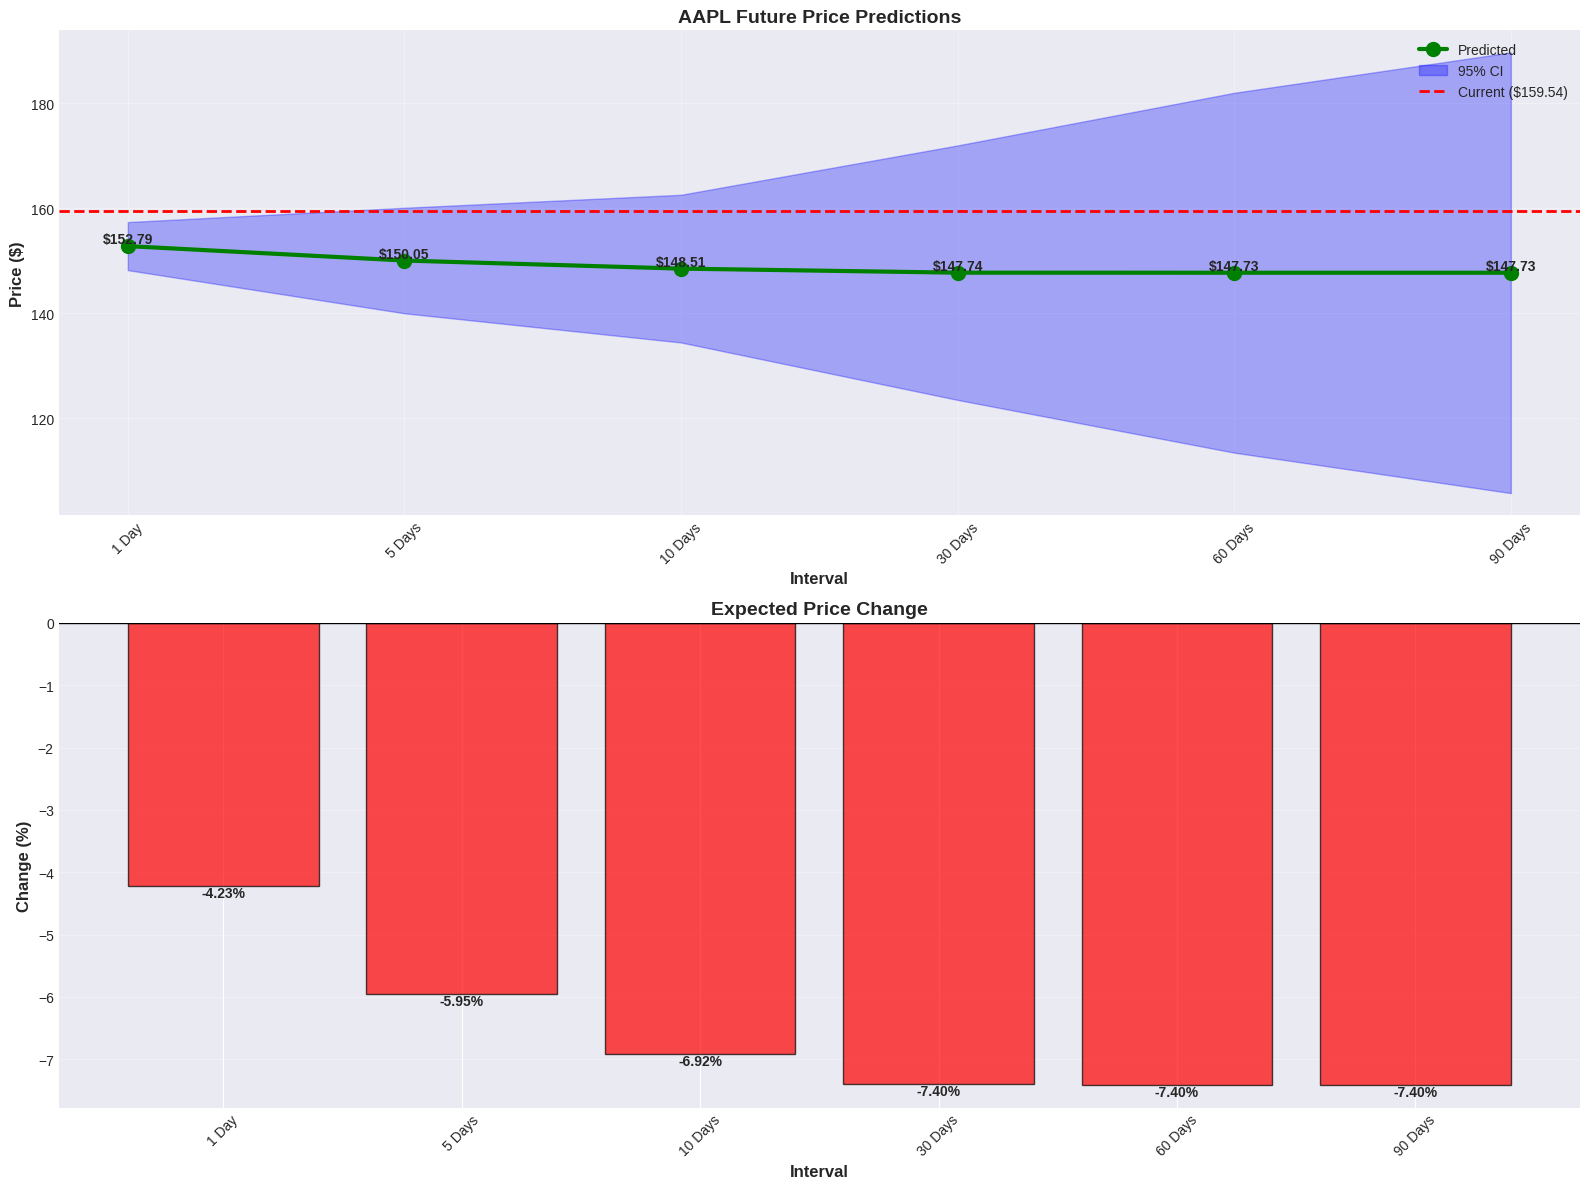

✅ Chart saved


In [50]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

intervals = predictions_df['Interval'].values
prices = predictions_df['Predicted_Price'].values
lower = predictions_df['Lower_95'].values
upper = predictions_df['Upper_95'].values

ax1.plot(intervals, prices, 'o-', linewidth=3, markersize=10, label='Predicted', color='green')
ax1.fill_between(range(len(intervals)), lower, upper, alpha=0.3, color='blue', label='95% CI')
ax1.axhline(y=current_price, color='red', linestyle='--', linewidth=2, label=f'Current (${current_price:.2f})')
ax1.set_xlabel('Interval', fontsize=12, fontweight='bold')
ax1.set_ylabel('Price ($)', fontsize=12, fontweight='bold')
ax1.set_title('AAPL Future Price Predictions', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)
for i, p in enumerate(prices):
    ax1.text(i, p, f'${p:.2f}', ha='center', va='bottom', fontweight='bold')

changes = predictions_df['Change_Percent'].values
colors = ['green' if x > 0 else 'red' for x in changes]
ax2.bar(intervals, changes, color=colors, alpha=0.7, edgecolor='black')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.set_xlabel('Interval', fontsize=12, fontweight='bold')
ax2.set_ylabel('Change (%)', fontsize=12, fontweight='bold')
ax2.set_title('Expected Price Change', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='x', rotation=45)
for i, c in enumerate(changes):
    ax2.text(i, c, f'{c:+.2f}%', ha='center', va='bottom' if c > 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.savefig(DIRS['results'] / 'future_predictions_chart.png', dpi=150)
plt.show()
print('✅ Chart saved')


## Step 16: Investment Analysis


In [51]:
short = predictions_df[predictions_df['Days'] <= 5]['Change_Percent'].mean()
medium = predictions_df[(predictions_df['Days'] > 5) & (predictions_df['Days'] <= 30)]['Change_Percent'].mean()
long = predictions_df[predictions_df['Days'] > 30]['Change_Percent'].mean()

print('\n' + '='*80)
print('💰 INVESTMENT OUTLOOK')
print('='*80)
print(f'Short-term (1-5 days): {short:+.2f}%')
if short > 1:
    print('  📈 BULLISH - Consider buying')
elif short < -1:
    print('  📉 BEARISH - Wait or short')
else:
    print('  ➡️  NEUTRAL - Hold')

print(f'\nMedium-term (10-30 days): {medium:+.2f}%')
if medium > 2:
    print('  📈 BULLISH - Good for swing trading')
elif medium < -2:
    print('  📉 BEARISH - Protective measures')
else:
    print('  ➡️  NEUTRAL - Hold positions')

print(f'\nLong-term (60-90 days): {long:+.2f}%')
if long > 3:
    print('  📈 BULLISH - Strong buy for long-term')
elif long < -3:
    print('  📉 BEARISH - Reconsider positions')
else:
    print('  ➡️  NEUTRAL - Balanced portfolio')

print('\n⚠️  DISCLAIMER: For educational purposes only. Not financial advice.')
print('='*80)



💰 INVESTMENT OUTLOOK
Short-term (1-5 days): -5.09%
  📉 BEARISH - Wait or short

Medium-term (10-30 days): -7.16%
  📉 BEARISH - Protective measures

Long-term (60-90 days): -7.40%
  📉 BEARISH - Reconsider positions

⚠️  DISCLAIMER: For educational purposes only. Not financial advice.


In [52]:
report = f'''\n{'='*80}
AAPL STOCK PREDICTION REPORT
{'='*80}

Generated: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
Model: LSTM Neural Network

CURRENT STATUS:
Stock: AAPL
Current Price: ${current_price:.2f}
Date: {current_date.strftime("%Y-%m-%d")}

PREDICTIONS:
{predictions_df.to_string(index=False)}

MODEL PERFORMANCE:
MAE: ${mae:.2f}
RMSE: ${rmse:.2f}
R²: {r2:.4f}

OUTLOOK:
Short-term: {short:+.2f}%
Medium-term: {medium:+.2f}%
Long-term: {long:+.2f}%

DISCLAIMER:
For educational purposes only. Not financial advice.
{'='*80}
'''

print(report)
with open(DIRS['results'] / 'report.txt', 'w') as f:
    f.write(report)
print(f'✅ Report saved to {DIRS["results"] / "report.txt"}')
print('\n🎉 COMPLETE!')



AAPL STOCK PREDICTION REPORT

Generated: 2025-12-22 21:03:37
Model: LSTM Neural Network

CURRENT STATUS:
Stock: AAPL
Current Price: $159.54
Date: 2018-02-07

PREDICTIONS:
Interval  Days  Predicted_Price   Lower_95   Upper_95  Change_Dollar  Change_Percent Direction
   1 Day     1       152.794804 148.221803 157.367805      -6.745196       -4.227903    📉 DOWN
  5 Days     5       150.048345 140.006606 160.090084      -9.491655       -5.949389    📉 DOWN
 10 Days    10       148.507488 134.452157 162.562818     -11.032512       -6.915201    📉 DOWN
 30 Days    30       147.738262 123.519813 171.956711     -11.801738       -7.397354    📉 DOWN
 60 Days    60       147.727252 113.479745 181.974759     -11.812748       -7.404255    📉 DOWN
 90 Days    90       147.727230 105.782778 189.671682     -11.812770       -7.404268    📉 DOWN

MODEL PERFORMANCE:
MAE: $8.93
RMSE: $10.06
R²: 0.0249

OUTLOOK:
Short-term: -5.09%
Medium-term: -7.16%
Long-term: -7.40%

DISCLAIMER:
For educational purposes onl

#### checking to see what model acutally learn

In [53]:
# Check the actual last data points the model saw
print("="*80)
print("DIAGNOSTIC: What data did the model see?")
print("="*80)

last_60 = df_apple.tail(60)
print(f"\nLast 60 days in dataset:")
print(f"Date range: {last_60['date'].min()} to {last_60['date'].max()}")
print(f"Starting price: ${last_60['close'].iloc[0]:.2f}")
print(f"Ending price: ${last_60['close'].iloc[-1]:.2f}")
print(f"Change: {((last_60['close'].iloc[-1] - last_60['close'].iloc[0]) / last_60['close'].iloc[0] * 100):+.2f}%")

print(f"\nTechnical Indicators at end:")
print(f"MA_7: ${last_60['MA_7'].iloc[-1]:.2f}")
print(f"MA_21: ${last_60['MA_21'].iloc[-1]:.2f}")
print(f"RSI: {last_60['RSI'].iloc[-1]:.2f}")
print(f"MACD: {last_60['MACD'].iloc[-1]:.4f}")

if last_60['close'].iloc[-1] < last_60['close'].iloc[0]:
    print("\n📉 The last 60 days showed DOWNTREND - Model learned to predict DOWN")
else:
    print("\n📈 The last 60 days showed UPTREND - But model still predicts DOWN (problem!)")

print("\n⚠️  CRITICAL: This dataset is from 2013-2018")
print("   Predictions are for 2018, not 2024!")
print("   For real predictions, you need CURRENT data!")
print("="*80)

DIAGNOSTIC: What data did the model see?

Last 60 days in dataset:
Date range: 2017-11-10 00:00:00 to 2018-02-07 00:00:00
Starting price: $174.67
Ending price: $159.54
Change: -8.66%

Technical Indicators at end:
MA_7: $163.11
MA_21: $171.17
RSI: 22.07
MACD: -3.4127

📉 The last 60 days showed DOWNTREND - Model learned to predict DOWN

⚠️  CRITICAL: This dataset is from 2013-2018
   Predictions are for 2018, not 2024!
   For real predictions, you need CURRENT data!
